# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# Main Refrence (book) : Machine Learning with Apache Spark Quick Start Guide

# import libraries
 
from pyspark.sql import SparkSession # to create Spark session
from pyspark.sql.functions import count, when, isnull, col, substring, from_unixtime, dayofmonth, month, countDistinct, datediff, current_date
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql.types import DateType, IntegerType  , ArrayType, FloatType, DoubleType, Row
from pyspark.sql.functions import avg   , desc, min, max, sum, split, udf, rand, struct, isnan, to_date, lit
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.linalg import DenseVector, SparseVector
from pyspark.ml.classification import LinearSVC, LogisticRegression, RandomForestClassifier, GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import seaborn as sns



'\nimport pandas as pd\n%matplotlib inline\nimport datetime\n\n'

In [2]:
# create a Spark session

spark = SparkSession.builder.appName("Sparkify").getOrCreate()


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
df = spark.read.json("mini_sparkify_event_data.json")

In [4]:
# To improve performance
df.persist()

DataFrame[artist: string, auth: string, firstName: string, gender: string, itemInSession: bigint, lastName: string, length: double, level: string, location: string, method: string, page: string, registration: bigint, sessionId: bigint, song: string, status: bigint, ts: bigint, userAgent: string, userId: string]

In [5]:
# count rows in the dataset
df.count()

286500

In [6]:
# sample of dataset content
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [7]:
# register the dataframe as a SQL temporary view
df.createOrReplaceTempView('logs')

In [8]:
# Assesing potential null values
df.select([count(when(isnull(c), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [9]:
# Explore missing values in the artist column
df.where(col('artist').isNull()).show()

+------+----------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null| Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|
|  null| Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|     9|
|  null| Logged In|    Mi

- *'artist'* column has many empty values, but not null

In [10]:
# Explore missing values in firstName column
df.where(col('firstName').isNull()).show()

+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method| page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+-----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET| Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET| Home|        null|        8|null|   200|1538355841000|     null|      |
|  null|Logged Out|     null|  nul

- *'firstName'* column also has many empty values, but not null

In [11]:
# Excloude 'logged Out' users, because we are want to focus on users activities while logged-in
df = df.where(col('auth') != 'Logged Out')

In [12]:
# also exclude when userid is not present
df = df.where(col('userId') != '')
# df = df.where(col('sessionId') != '')

In [13]:
# count rows in the dataset after dropping the exclouded records
df.count()

278154

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [14]:
# Explore the dataset schema
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [15]:
# Display sample of the first few rows
df.show(7)

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|      Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|    Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|Next

In [16]:
# count distinct user_ids
spark.sql("select count(distinct(userId)) from logs").show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   226|
+----------------------+



In [17]:
# Check levels of subscription
spark.sql('''
          SELECT DISTINCT level
          FROM logs 
          ORDER BY level ASC
          '''
          ).show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [18]:
# Count records for each level
df.groupBy('level').count().show()

+-----+------+
|level| count|
+-----+------+
| free| 55721|
| paid|222433|
+-----+------+



In [19]:
# Count gender of users
df.groupBy('gender').count().show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+



In [20]:
# Count users agents (browesers)
df.groupBy('userAgent').count().show()

+--------------------+-----+
|           userAgent|count|
+--------------------+-----+
|"Mozilla/5.0 (Mac...|  240|
|"Mozilla/5.0 (Win...| 5238|
|Mozilla/5.0 (X11;...|   62|
|"Mozilla/5.0 (Mac...|18448|
|"Mozilla/5.0 (Mac...| 1262|
|Mozilla/5.0 (Maci...| 2442|
|Mozilla/5.0 (Wind...| 3214|
|Mozilla/5.0 (Wind...| 5989|
|Mozilla/5.0 (comp...| 8624|
|"Mozilla/5.0 (Win...| 7624|
|Mozilla/5.0 (Maci...|10300|
|"Mozilla/5.0 (Win...| 2168|
|"Mozilla/5.0 (iPh...| 1976|
|"Mozilla/5.0 (Win...|15395|
|Mozilla/5.0 (Wind...|16700|
|Mozilla/5.0 (comp...| 1245|
|Mozilla/5.0 (comp...|  815|
|"Mozilla/5.0 (Mac...|  235|
|"Mozilla/5.0 (Mac...|  512|
|"Mozilla/5.0 (Win...|14598|
+--------------------+-----+
only showing top 20 rows



In [21]:
# list app pages
spark.sql('''
          SELECT DISTINCT page
          FROM logs 
          ORDER BY page ASC
          '''
          ).show(30)

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
|           Thumbs Up|
|             Upgrade|
+--------------------+



In [22]:
# Count all the page events
df.groupBy('Page').count().show()

+--------------------+------+
|                Page| count|
+--------------------+------+
|              Cancel|    52|
|    Submit Downgrade|    63|
|         Thumbs Down|  2546|
|                Home| 10082|
|           Downgrade|  2055|
|         Roll Advert|  3933|
|              Logout|  3226|
|       Save Settings|   310|
|Cancellation Conf...|    52|
|               About|   495|
|            Settings|  1514|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Help|  1454|
|             Upgrade|   499|
|               Error|   252|
|      Submit Upgrade|   159|
+--------------------+------+



### What Defined a Churned Users ?

It's done by identifing cancellation confirmation events. Then creating an indicator that a user will churn. Such approach allows us to study behavior prior to churning to try and build a predictive model and extract behaviors that indicate a risk of churning in the future.


In [23]:
################### Churned OR not ###################

# Create a dataset with users who churned
churn = spark.sql('SELECT DISTINCT userId, 1 as churn FROM logs WHERE Page = "Cancellation Confirmation"')

# Create a dataset for other users
no_churn = spark.sql('SELECT DISTINCT userId, 0 as churn FROM logs \
                      WHERE userId NOT IN (SELECT DISTINCT userId FROM logs WHERE Page = "Cancellation Confirmation")')

# Create a dataframe from the union of the two, also shuffling the rows in a random manner
churn_df = churn.union(no_churn)
churn_df.createOrReplaceTempView('churn')
churn_df = spark.sql('SELECT * FROM churn ORDER BY RAND()')
churn_df.createOrReplaceTempView('churn')

In [24]:
# Check number of users, it should be the same as we got before '226'
churn_df.count()

226

In [25]:
# Get number of users who churn AND number of users who did not
churn_pd_df = churn_df.toPandas()
churn_pd_df.groupby('churn', as_index=False).count()

,churn,userId
0,0,174
1,1,52


### Observation on Number of Churned

Notice that number of users who didn't churn is around 3 times  those who churned. This will impact modle building in a later stage.


# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [26]:
# Join our churn dataset to our full dataset to add a column
joined_df = df.join(churn_df, on='userId')

# Use this column to create some aggregates, first comparing the level of the account
joined_df.groupBy(['churn', 'level']).count().show(5)

+-----+-----+------+
|churn|level| count|
+-----+-----+------+
|    0| free| 43333|
|    0| paid|189957|
|    1| paid| 32476|
|    1| free| 12388|
+-----+-----+------+



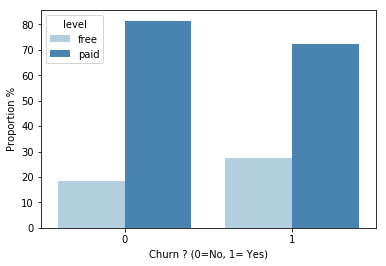

In [27]:
# Plot a bar chart of users' proportions

level_df = joined_df.groupBy(['churn', 'level']).count().toPandas()
churn_sum = level_df.groupby('churn', as_index=False).sum()
level_df['proportion'] = (level_df.join(churn_sum, on = 'churn', lsuffix='_1')['count_1']/level_df.join(churn_sum, on = 'churn', lsuffix='_1')['count'])*100

g = sns.barplot(x="churn", y="proportion", hue="level", data=level_df, palette = 'Blues')
g.set(xlabel='Churn ? (0=No, 1= Yes)', ylabel="Proportion %")
plt.show();

### Free Users who Churned

Around 20% of free sub. users did NOT churned, while around 30% of free sub. users churned


In [28]:
# Get churn average length
joined_df.groupBy('churn').avg('length').show(5)

+-----+------------------+
|churn|       avg(length)|
+-----+------------------+
|    1| 248.6327956440622|
|    0|249.20913538880814|
+-----+------------------+



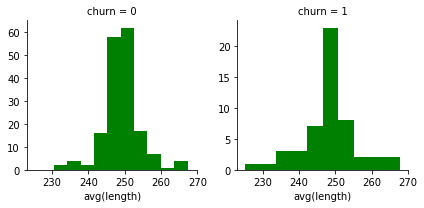

In [29]:
# Average length for every user
length_df = joined_df.groupBy(['userId', 'churn']).avg('length').toPandas()

# plot distribution of length between two users groups
g = sns.FacetGrid(length_df, col="churn", sharey=False)
g.map(plt.hist, "avg(length)",color='g');

In [30]:
# The itemInSession variable, which represents the rank fo the song in the current sessionk
joined_df.groupBy('churn').avg('itemInSession').show(5)

+-----+------------------+
|churn|avg(itemInSession)|
+-----+------------------+
|    1|109.23299304564907|
|    0| 115.9888465000643|
+-----+------------------+



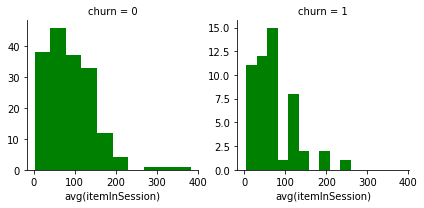

In [31]:
# We also plot distribution between both groups
item_df = joined_df.groupBy(['userId','churn']).avg('itemInSession').toPandas()
g = sns.FacetGrid(item_df, col="churn", sharey=False)
g.map(plt.hist, "avg(itemInSession)",color='g');

In [32]:
# Create a variable representing the state
joined_df = joined_df.withColumn('state', substring(col("location"), -2, 3))

# See the most present states for people who churned 
joined_df.groupBy(['churn', 'state']).count().where(joined_df['churn'] == 0).sort(col('count').desc()).show()
joined_df.groupBy(['churn', 'state']).count().where(joined_df['churn'] == 1).sort(col('count').desc()).show()

+-----+-----+-----+
|churn|state|count|
+-----+-----+-----+
|    0|   CA|39158|
|    0|   PA|23708|
|    0|   TX|22200|
|    0|   NH|18637|
|    0|   FL|11427|
|    0|   NC|10572|
|    0|   WI| 8097|
|    0|   SC| 7954|
|    0|   NJ| 7816|
|    0|   IN| 7312|
|    0|   MD| 6752|
|    0|   CT| 6720|
|    0|   VA| 6514|
|    0|   WV| 6192|
|    0|   IL| 6112|
|    0|   MI| 5258|
|    0|   AZ| 4595|
|    0|   GA| 4236|
|    0|   NY| 4079|
|    0|   AK| 3563|
+-----+-----+-----+
only showing top 20 rows

+-----+-----+-----+
|churn|state|count|
+-----+-----+-----+
|    1|   CA| 7613|
|    1|   CO| 4317|
|    1|   MS| 3839|
|    1|   WA| 3526|
|    1|   OH| 3173|
|    1|   KY| 3016|
|    1|   PA| 2899|
|    1|   AL| 2102|
|    1|   MI| 1958|
|    1|   MD| 1848|
|    1|   FL| 1763|
|    1|   TX| 1294|
|    1|   NC| 1199|
|    1|   MO| 1003|
|    1|   IN|  918|
|    1|   IL|  848|
|    1|   WI|  600|
|    1|   AR|  582|
|    1|   KS|  513|
|    1|   SC|  494|
+-----+-----+-----+
only showing t

In [33]:
# get potential differences based on ts
joined_df.groupBy('churn').avg('ts').show()

+-----+--------------------+
|churn|             avg(ts)|
+-----+--------------------+
|    1|1.539919263874465E12|
|    0|1.541158850823305...|
+-----+--------------------+



In [34]:
# since ts column is a unix timestamp, we convert to date format
joined_df = joined_df.withColumn('date', from_unixtime((col('ts')/1000)).cast(DateType()))

# Then we can create several time based features:

# 1) extract day and month from the date column
joined_df = joined_df.withColumn('day', dayofmonth('date')).withColumn('month', month('date'))

# 2) for a given user get the average number of distinct sessions per day & per month
day_df = joined_df.groupBy(['userId', 'day']).agg(countDistinct('sessionId')).groupBy('userId').avg('count(DISTINCT sessionId)').withColumnRenamed('avg(count(DISTINCT sessionId))', 'daily_sessions')
month_df = joined_df.groupBy(['userId', 'month']).agg(countDistinct('sessionId')).groupBy('userId').avg('count(DISTINCT sessionId)').withColumnRenamed('avg(count(DISTINCT sessionId))', 'monthly_sessions')

# 3) join this information back to the original joined_df for each row for a given userId, it will be used later
joined_df = joined_df.join(day_df, on='userId').join(month_df, on='userId')

In [35]:
# Compare monthly & daily sessions for both users groups
joined_df.groupBy('churn').avg('monthly_sessions').show()
joined_df.groupBy('churn').avg('daily_sessions').show()

+-----+---------------------+
|churn|avg(monthly_sessions)|
+-----+---------------------+
|    1|   10.472394347360913|
|    0|   14.987535542315017|
+-----+---------------------+

+-----+-------------------+
|churn|avg(daily_sessions)|
+-----+-------------------+
|    1|  1.427520820895794|
|    0| 1.6932722878596427|
+-----+-------------------+



In [36]:
# registration date is unix timestamp too, so we convert to actual date
joined_df = joined_df.withColumn('registration_date', from_unixtime((col('registration')/1000)).cast(DateType()))

# create a new feature capturing the month of the year when they registered, to account for potential promotions
joined_df = joined_df.withColumn('month_registration', month('registration_date'))

# create a new feature capturing the number of days since registration
joined_df = joined_df.withColumn('days_since_registration', datediff(current_date(), col('registration_date')))

In [37]:
# check if user agent make diffrence
joined_df.groupBy(['churn', 'userAgent']).count().where(joined_df['churn'] == 0).sort(col('count').desc()).show()
joined_df.groupBy(['churn', 'userAgent']).count().where(joined_df['churn'] == 1).sort(col('count').desc()).show()

+-----+--------------------+-----+
|churn|           userAgent|count|
+-----+--------------------+-----+
|    0|"Mozilla/5.0 (Win...|18226|
|    0|"Mozilla/5.0 (Mac...|16298|
|    0|"Mozilla/5.0 (Mac...|15914|
|    0|"Mozilla/5.0 (Win...|15237|
|    0|Mozilla/5.0 (Wind...|15224|
|    0|"Mozilla/5.0 (Mac...|14875|
|    0|"Mozilla/5.0 (Win...|12823|
|    0|"Mozilla/5.0 (iPa...| 8912|
|    0|Mozilla/5.0 (comp...| 8624|
|    0|Mozilla/5.0 (Maci...| 7838|
|    0|"Mozilla/5.0 (Mac...| 7638|
|    0|"Mozilla/5.0 (Win...| 6531|
|    0|"Mozilla/5.0 (Mac...| 6165|
|    0|"Mozilla/5.0 (Mac...| 5716|
|    0|"Mozilla/5.0 (Win...| 5553|
|    0|"Mozilla/5.0 (iPh...| 5407|
|    0|"Mozilla/5.0 (Win...| 5238|
|    0|Mozilla/5.0 (Wind...| 4925|
|    0|"Mozilla/5.0 (Win...| 3985|
|    0|"Mozilla/5.0 (Win...| 3432|
+-----+--------------------+-----+
only showing top 20 rows

+-----+--------------------+-----+
|churn|           userAgent|count|
+-----+--------------------+-----+
|    1|"Mozilla/5.0 (Mac...| 

In [38]:
''' 

For a given user we compute:
- number of downgrades
- upgrades
- thumbs up-
- thumbs down
- add friend
- add to playlist
- roll advert

'''

# Create a column for each of these events, with "1" each time they occur
for c in ['Downgrade', 'Roll Advert', 'Thumbs Down', 'Add to Playlist', 'Add Friend', 'Thumbs Up']:
    joined_df = joined_df.withColumn(c, (joined_df['Page'] == c).cast(IntegerType()))
    
# Prepare data for the pipeline
features_df = joined_df.groupBy('userId').agg(avg('itemInSession'), avg('length'), min('daily_sessions'), min('monthly_sessions'), min('days_since_registration'), min('month_registration'), max('level'), max('userAgent'), max('state'), sum('Downgrade'), sum('Roll Advert'), sum('Thumbs Down'), sum('Add to Playlist'), sum('Add Friend'), sum('Thumbs Up'), max('churn'))

features_df = features_df.select(col('avg(itemInSession)').alias('itemInSession'),
                                 col('avg(length)').alias('length'),
                                 col('min(daily_sessions)').alias('daily_sessions'),
                                 col('min(monthly_sessions)').alias('monthly_sessions'),
                                 col('min(days_since_registration)').alias('days_since_registration'),
                                 col('min(month_registration)').alias('month_registration'),
                                 col('max(state)').alias('state'),
                                 col('max(level)').alias('level'),
                                 col('max(userAgent)').alias('userAgent'),
                                 col('sum(Downgrade)').alias('downgrade'),
                                 col('sum(Roll Advert)').alias('rollAdvert'),
                                 col('sum(Thumbs Down)').alias('thumbsDown'),
                                 col('sum(Add to Playlist)').alias('addToPlaylist'),
                                 col('sum(Add Friend)').alias('addFriend'),
                                 col('sum(Thumbs Up)').alias('thumbsUp'),
                                 col('max(churn)').alias('label'))

In [39]:
# check if we have null values
features_df.select([count(when(isnull(c), c)).alias(c) for c in features_df.columns]).show()

+-------------+------+--------------+----------------+-----------------------+------------------+-----+-----+---------+---------+----------+----------+-------------+---------+--------+-----+
|itemInSession|length|daily_sessions|monthly_sessions|days_since_registration|month_registration|state|level|userAgent|downgrade|rollAdvert|thumbsDown|addToPlaylist|addFriend|thumbsUp|label|
+-------------+------+--------------+----------------+-----------------------+------------------+-----+-----+---------+---------+----------+----------+-------------+---------+--------+-----+
|            0|     0|             0|               0|                      0|                 0|    0|    0|        0|        0|         0|         0|            0|        0|       0|    0|
+-------------+------+--------------+----------------+-----------------------+------------------+-----+-----+---------+---------+----------+----------+-------------+---------+--------+-----+



In [40]:
# Drop the found null values
features_df = features_df.where(col("userAgent").isNotNull()).where(col("state").isNotNull())

### Notes on Features

- length : on average is same but we will include in our model as it seems to have diffrent distibution betwween both groups.
- item in session: which can be understood as number of songs in the sesion. So we will include it in the model.
- ts, registration : will be included in the model as they are indecation of churn possiblity; however they are in unix timestamp format and have to be converted.
- app behaviors (thumbs up, down, ..) : will be included in the model.


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [41]:
# First create a pipeline to prepare our data for modeling
indexer_state = StringIndexer(inputCol='state', outputCol='state_index')
indexer_level = StringIndexer(inputCol='level', outputCol='level_index')
indexer_ua = StringIndexer(inputCol='userAgent', outputCol='userAgent_index')
assembler = VectorAssembler(inputCols=['itemInSession', 'length','daily_sessions','monthly_sessions','days_since_registration'
                                       ,'month_registration','level_index', 'state_index','userAgent_index','downgrade'
                                       ,'rollAdvert','thumbsDown','addToPlaylist','addFriend','thumbsUp'], outputCol='features')

features_pipeline = Pipeline(stages=[indexer_state, indexer_level, indexer_ua, assembler])

model_df = features_pipeline.fit(features_df).transform(features_df)

In [42]:
# Due to data structure, convert some features vector from Sparse-to-Dense
df2 = model_df.select("label", "features")
rdd = df2.rdd.map(lambda x: Row(label=x[0],features=DenseVector(x[1].toArray()))
                     if (len(x)>1 and hasattr(x[1], "toArray"))
                     else Row(label=None, features=DenseVector([])))
model_data = spark.createDataFrame(rdd)

### Abandoed Algorethms
I tested the following algorithms but decded not to use them
- BinaryClassificationEvaluator : it wasn't suitable for this dataset
- Support Vector Machine : the execution time is very long. It toke forever to run. I waited hours with no results and many times my notebook timedout


In [43]:
# Function to train and estimate a model
def fitEstimate(train, test, model):
    '''
    Fits and estimates different classification models with the default parameters
    
    INPUT:
    train (Spark df): a Spark data frame with training data
    test (Spark df): a Spark data frame with testing data
    model (string): a string specifing the models to fitted
    
    OUTPUT:
    None, prints accuracy of the model
    '''
    # Choose the model
    if model == 'logistic_regression':
        ml = LogisticRegression()
    elif model == 'random_forest':
        ml = RandomForestClassifier()
    elif model == 'gradient_boosting':
        ml = GBTClassifier()
    else:
        return "Choose appropriate model"
    
    # Fit and calculate predictions
    classification = ml.fit(train)
    results = classification.transform(test)
    
    # Calculate accuracy and F-1 score
    accuracy_evaluator = MulticlassClassificationEvaluator(metricName='accuracy')
    accuracy = accuracy_evaluator.evaluate(results.select(col('label'), col('prediction')))
    
    f1_score_evaluator = MulticlassClassificationEvaluator(metricName='f1')
    f1_score = f1_score_evaluator.evaluate(results.select(col('label'), col('prediction')))
    
    print('{} accuracy on the test set is {:.2%} and the F-1 score is {}'\
    .format(model, accuracy, f1_score))

In [44]:
# Split this data between train, validation and test sets
train, test = model_data.randomSplit([0.8, 0.2], seed=42)

# Due to the class imbalance, we upsample the categories who churned in the training dataset
print('In our training set, before upsampling we have {} users who churned and {} who did not.'.format(train.where(col('label') == 1).count(), train.where(col('label') == 0).count()))

train_churn = train.where(col('label') == 1).sample(True, train.where(col('label') == 0).count()/train.where(col('label') == 1).count())
train_no_churn = train.where(col('label') == 0)
train = train_churn.unionAll(train_no_churn)

In our training set, before upsampling we have 41 users who churned and 150 who did not.


In [45]:
# Fit various models and evalute their accuracies
for model in ['logistic_regression', 'random_forest', 'gradient_boosting']:
    fitEstimate(train, test, model)

logistic_regression accuracy on the test set is 58.82% and the F-1 score is 0.6003016591251885
random_forest accuracy on the test set is 70.59% and the F-1 score is 0.6973039215686275
gradient_boosting accuracy on the test set is 76.47% and the F-1 score is 0.7578431372549018


### Thought in Models

To be honest, the models' results are not stable. In a sense that evertime we run Fit-Estimator we got slightly diffrent numbers. This could be due dealing with small sample (128 MB) of the 12 GB dataset.

On avreage "Gradient Boosting" gives better results on many runs. In the last run we achive 76.47% accuracy and 0.76 F-1 score.


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

## EXTRA

# Conclusion

With historical log data in hand, we used Spark a Random Forest model to predict churn for Sparkify's users. A combination of behavioral and static features allow us to reach 73% accuracy on the test set, and a F1 score around 0.7 ensures we have struck a good balance between precision and recall. Leveraging methods such as SHAP values, partial plots or permutation importance could allow us to derive even better insights by quantifying the impact of given variables.

Sparkify can leverage this model to take mitigating action against churn, thus improving revenue and growth. For instance, the model could be run every day (or week depending on the computing infrastructure) and once a user is flagged as likely to churn, personalized messages or discounts could be sent. Which action to take should be determined though A/B testing to ensure rigor and statistical significance so as not to waste money.

It is important that this model be re-trained regularly to avoid making decisions on outdated data as the user base and consumer behavior evolve. If Sparkify has access to a cluster (AWS or IBM Cloud for instance), it would be interesting to replicate this analysis on a larger subset of the log data to extract more robust insight. Here, our inability to improve the performance of our model through GridSearch most likely reflects the limitations from the size of the dataset, and working with more data could improve performance further and allow a more extensive search over the hyper-parameter space, making this model even more robust and useful for Sparkify.